In [19]:
import os
import sys
import torch
import pickle
import torch.nn as nn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))

from model.CNN_model import CNNTextClassifier
from model.BiLSTM_model import BiLSTMModel
from language_model import train, evaluate
from evaluation import confusion_matrix, class_accuracy, class_f1_score,\
    class_wise_precision_recall, plot_confusion_matrix
from utils import tokenize, remove_stopwords, stemming, fit_tokenizer, plot_loss_acc,\
    pad_sequence, PandasDataset, get_batched_data, get_class_weights, split_train_val_dataloader 

# Data Preparation

In [2]:
data = pd.read_csv("../data/text.csv").drop(columns="Unnamed: 0")
data.sample(10)

,text,label
326935,i go into or the more happiness i feel the mor...,1
410898,i feel like its just about all i talk about th...,0
215052,i was feeling what would be the perfect respon...,1
263533,i am feeling really homesick and hence out of ...,0
374711,i am quite pleased with myself and i am feelin...,1
81452,i open it up and go through the pieces of pape...,1
113546,i feel good about especially in my daily routi...,1
16023,i feel invigorated and jolly,1
147565,i was starting to feel this wonderful unity wi...,1
72871,i accomplish little i feel defeated and frustr...,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [4]:
# data.duplicated().sum()
data.drop_duplicates(inplace= True)

### Tokenize, stem and remove stopwords 

In [6]:
data['tokens_stemm'] = data['text'].apply(tokenize).apply(remove_stopwords).apply(stemming)
# data['tokens_stemm'] = data['tokens']
data = data[~(data['tokens_stemm'].apply(len) == 0)]
data.sample(10)

,text,label,tokens_stemm
310807,i stare into the flames i can t help but feel ...,1,"[stare, flame, help, feel, thank]"
166328,i really think anyone reads this but i still f...,0,"[realli, think, anyon, read, still, feel, negl..."
10922,i like to cry at stories that touch my heart a...,0,"[like, cri, stori, touch, heart, feel, real, e..."
397526,i run more lose weight my pace gets better and...,1,"[run, lose, weight, pace, get, better, feel, b..."
277673,i love the way i feel after a night of sweet d...,2,"[love, way, feel, night, sweet, deep, sleep, b..."
348132,i feel an urgency to see your handsome face,1,"[feel, urgenc, see, handsom, face]"
143840,i didn t really test it yet but i can feel the...,1,"[realli, test, yet, feel, differ, laptop, casu..."
370990,i feel hated helping prevent gay teen suicide ...,3,"[feel, hate, help, prevent, gay, teen, suicid,..."
68572,i most feel how precious each minute with him ...,1,"[feel, preciou, minut, quickli, day, pass]"
13257,i actually go to the show i didnt feel weird o...,5,"[actual, go, show, didnt, feel, weird, place]"


### Split data into train and test sets. Calculate class weights.

In [7]:
# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(data['tokens_stemm'], data['label'], test_size=0.2, random_state=42)
# Calculate class weights
class_weights = get_class_weights(data['label'])
print(f"Class Weights : {class_weights}")

train_data = pd.concat((x_train,y_train), axis=1).reset_index()
test_data = pd.concat((x_test,y_test), axis=1).reset_index()
print(f"Train size: {len(train_data)}\tTest size: {len(test_data)}")

Class Weights : tensor([0.5732, 0.4926, 2.0104, 1.2118, 1.4551, 4.6361])
Train size: 332886	Test size: 83222


### Fit tokenizer

In [8]:
tokenizer = fit_tokenizer(data['tokens_stemm'])
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved to file.")

Tokenizer saved to file.


### Pad the sequences to have uniform length. Batch the data for training.

In [9]:
train_data['padded'] = train_data['tokens_stemm'].apply(pad_sequence, tokenizer= tokenizer)
test_data['padded'] = test_data['tokens_stemm'].apply(pad_sequence, tokenizer= tokenizer)
print("Data prepared for model!")
train_dataset = PandasDataset(train_data)
test_dataset = PandasDataset(test_data)
train_batched = get_batched_data(train_dataset, batch_size= 256)
test_batched = get_batched_data(test_dataset, batch_size= 64)

Data prepared for model!


# CNN

### Initialise the model

In [16]:
model = CNNTextClassifier()
print(model)

CNNTextClassifier(
  (embedding): Embedding(52000, 32)
  (conv): Sequential(
    (0): Conv1d(32, 24, kernel_size=(5,), stride=(1,))
    (1): MaxPool1d(kernel_size=96, stride=96, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (dense): Sequential(
    (0): Linear(in_features=24, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=6, bias=True)
    (3): Softmax(dim=1)
  )
)


In [17]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters: 1668366


### Train the model

In [18]:
model, losses, accs = train(model, train_batched, num_epochs= 6,
                            lr= 0.001, lr_floor= 0.00001,
                            class_weights= class_weights)

  0%|          | 0/976 [00:00<?, ?it/s]

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
)


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 1/3, Iter 1/4 Train Loss: 1.4862, Train Accuracy: 49.225%, Val Accuracy: 77.933%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 1/3, Iter 2/4 Train Loss: 1.3380, Train Accuracy: 66.358%, Val Accuracy: 87.043%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 1/3, Iter 3/4 Train Loss: 1.2735, Train Accuracy: 73.705%, Val Accuracy: 89.887%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 1/3, Iter 4/4 Train Loss: 1.2367, Train Accuracy: 77.782%, Val Accuracy: 90.004%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 2/3, Iter 1/4 Train Loss: 1.1194, Train Accuracy: 90.559%, Val Accuracy: 90.655%


  0%|          | 1/976 [00:00<02:11,  7.41it/s]

Epoch 2/3, Iter 2/4 Train Loss: 1.1174, Train Accuracy: 90.729%, Val Accuracy: 91.004%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 2/3, Iter 3/4 Train Loss: 1.1159, Train Accuracy: 90.877%, Val Accuracy: 91.177%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 2/3, Iter 4/4 Train Loss: 1.1148, Train Accuracy: 90.996%, Val Accuracy: 91.440%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/3, Iter 1/4 Train Loss: 1.1095, Train Accuracy: 91.546%, Val Accuracy: 91.595%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/3, Iter 2/4 Train Loss: 1.1091, Train Accuracy: 91.598%, Val Accuracy: 91.613%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/3, Iter 3/4 Train Loss: 1.1087, Train Accuracy: 91.642%, Val Accuracy: 91.813%


100%|██████████| 976/976 [03:58<00:00,  4.10it/s]


Epoch 3/3, Iter 4/4 Train Loss: 1.1084, Train Accuracy: 91.677%, Val Accuracy: 91.835%


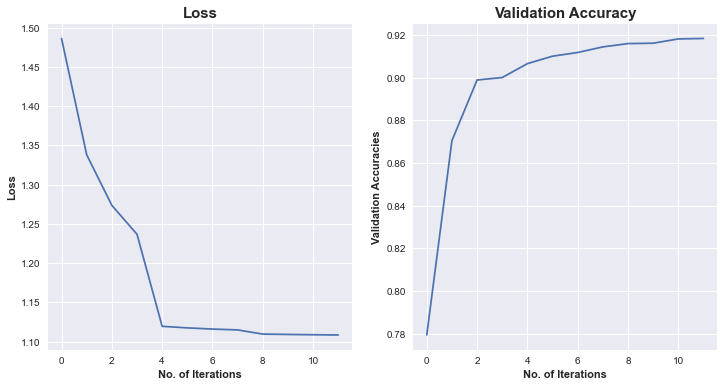

In [20]:
plot_loss_acc(loss= losses, accs= accs, modelname= 'cnn', plot= True)

  0%|          | 0/1301 [00:00<?, ?it/s]

-----------------------------------Evaluating model on test data------------------------------------


100%|██████████| 1301/1301 [00:49<00:00, 26.32it/s]


Average acccuracy: 85.29%
Average F1: 88.10%


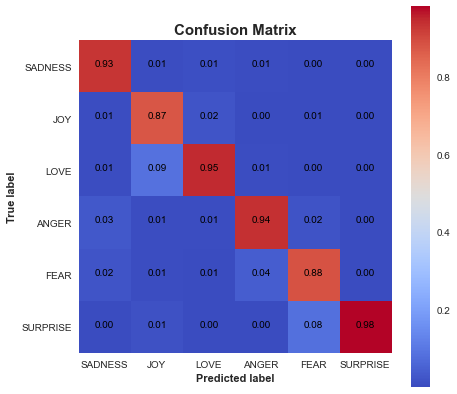

In [21]:
conf_mat = evaluate(model, test_batched)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'cnn', plot= True)

In [ ]:
accuracies = class_accuracy(conf_mat)
f1_scores = class_f1_score(conf_mat)
precisions, recalls = class_wise_precision_recall(conf_mat)

average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print(f"Average acccuracy: {average_accuracy*100:.2f}%")
print(f"Average F1: {average_f1*100:.2f}%")

output_df = pd.DataFrame({"Emotion":['Sadness','Joy','Love','Anger','Fear','Surprise'],
                            'Accuracy':accuracies, 'F1_Score':f1_scores,
                            'Precision':precisions, 'Recall':recalls})
print(output_df)

In [23]:
torch.save(model, f= "../model/cnn.pth")

# BiLSTM

In [43]:
from tqdm import tqdm
def train(model, train_dataloader, num_epochs:int, lr:float, lr_floor:float, class_weights:torch.FloatTensor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss(weight= class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr= lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                           T_max= num_epochs*4,
                                                           eta_min= lr_floor)
    print(criterion)
    print(optimizer)
    print(scheduler)

    epoch_loss, epoch_acc = [], []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_running_loss = 0.0
        train_correct_predictions = 0
        train_total_predictions = 0
        train_loaders, val_loaders = split_train_val_dataloader(train_dataloader)
        loop_ctr = 0
        for train_dl, val_dl in zip(train_loaders, val_loaders):
            loop_ctr += 1
            for batch in tqdm(train_dl):
                inputs = batch['padded'].to(device)
                labels = batch['label'].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                train_correct_predictions += (predicted == labels).sum().item()
                train_total_predictions += labels.size(0)
            scheduler.step()
            train_epoch_loss = train_running_loss / (len(train_dl.dataset)*loop_ctr)
            train_epoch_accuracy = train_correct_predictions / train_total_predictions
            # Validation phase
            model.eval()
            val_correct_predictions = 0
            val_total_predictions = 0
            with torch.no_grad():
                for batch in val_dl:
                    val_inputs = batch['padded'].to(device)
                    val_labels = batch['label'].to(device) 
                    val_outputs = model(val_inputs)
                    _, val_predicted = torch.max(val_outputs, 1)
                    val_correct_predictions += (val_predicted == val_labels).sum().item()
                    val_total_predictions += val_labels.size(0)
            val_epoch_accuracy = val_correct_predictions / val_total_predictions
            epoch_loss.append(train_epoch_loss)
            epoch_acc.append(val_epoch_accuracy)
            print(f'Epoch {epoch+1}/{num_epochs}, Iter {loop_ctr}/4 '
                f'Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy*100:.3f}%, '
                f'Val Accuracy: {val_epoch_accuracy*100:.3f}%')
        
    return model, epoch_loss, epoch_acc

In [47]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocabulary_size:int= 52000,
                 embedding_dim:int= 32, hidden_size:int= 16,
                 num_classes:int= 6,p:float= 0.3):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True)
        self.batchnorm = nn.BatchNorm1d(hidden_size * 2)
        self.dropout = nn.Dropout(p)
        self.dense = nn.Sequential(nn.Linear(hidden_size*2, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, num_classes),
                                   nn.Softmax(dim=1))
        
        # self.apply(init_weights)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Change shape for LSTM
        _, (x, _) = self.lstm(x)
        x = x.permute(1, 0, 2).contiguous().view(x.size(1), -1)  # Flatten LSTM output
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = self.dense(x)
        return x

### Initialize the model

In [48]:
model = BiLSTMModel()
print(model)

BiLSTMModel(
  (embedding): Embedding(52000, 32)
  (lstm): LSTM(32, 16, bidirectional=True)
  (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (dense): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=6, bias=True)
    (3): Softmax(dim=1)
  )
)


In [49]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters: 1671094


### Train the model

In [50]:
model, losses, accs = train(model, train_batched, num_epochs= 6,
                            lr= 0.001, lr_floor= 0.00001,
                            class_weights= class_weights)

  0%|          | 0/976 [00:00<?, ?it/s]

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
)


  0%|          | 1/976 [00:00<02:16,  7.15it/s]

Epoch 1/3, Iter 1/4 Train Loss: 1.5584, Train Accuracy: 39.013%, Val Accuracy: 67.534%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 1/3, Iter 2/4 Train Loss: 1.3985, Train Accuracy: 57.587%, Val Accuracy: 81.948%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 1/3, Iter 3/4 Train Loss: 1.3272, Train Accuracy: 65.923%, Val Accuracy: 84.131%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 1/3, Iter 4/4 Train Loss: 1.2863, Train Accuracy: 70.749%, Val Accuracy: 85.861%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 2/3, Iter 1/4 Train Loss: 1.1664, Train Accuracy: 84.720%, Val Accuracy: 86.729%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 2/3, Iter 2/4 Train Loss: 1.1570, Train Accuracy: 85.897%, Val Accuracy: 87.699%


  0%|          | 1/976 [00:00<02:45,  5.88it/s]

Epoch 2/3, Iter 3/4 Train Loss: 1.1521, Train Accuracy: 86.497%, Val Accuracy: 88.114%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 2/3, Iter 4/4 Train Loss: 1.1487, Train Accuracy: 86.927%, Val Accuracy: 88.317%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/3, Iter 1/4 Train Loss: 1.1442, Train Accuracy: 87.464%, Val Accuracy: 88.378%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/3, Iter 2/4 Train Loss: 1.1389, Train Accuracy: 88.082%, Val Accuracy: 88.806%


  0%|          | 0/976 [00:00<?, ?it/s]

Epoch 3/3, Iter 3/4 Train Loss: 1.1365, Train Accuracy: 88.358%, Val Accuracy: 88.921%


100%|██████████| 976/976 [02:30<00:00,  6.46it/s]


Epoch 3/3, Iter 4/4 Train Loss: 1.1353, Train Accuracy: 88.513%, Val Accuracy: 89.099%


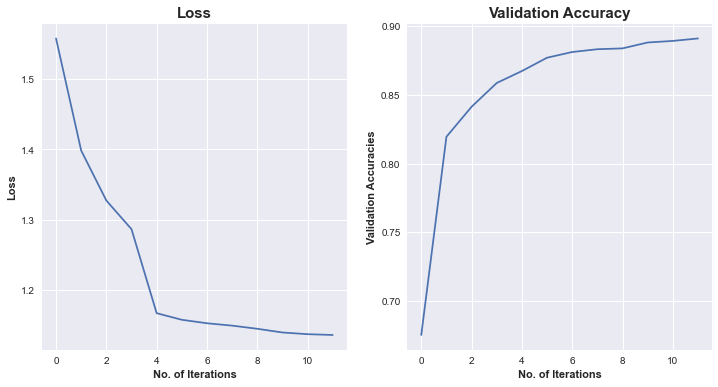

In [51]:
plot_loss_acc(loss= losses, accs= accs, modelname= 'bilstm', plot= True)

  0%|          | 4/1301 [00:00<00:39, 32.86it/s]

-----------------------------------Evaluating model on test data------------------------------------


100%|██████████| 1301/1301 [00:26<00:00, 49.95it/s]


Average acccuracy: 82.48%
Average F1: 85.38%


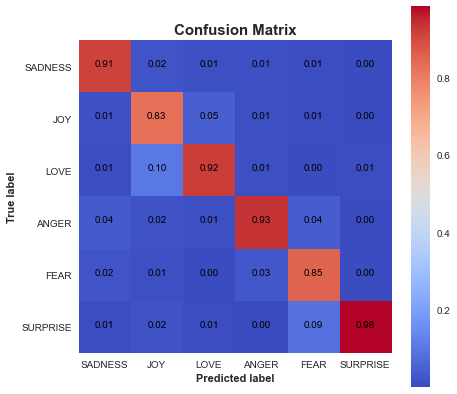

In [52]:
conf_mat = evaluate(model, test_batched)
plot_confusion_matrix(conf_matrix= conf_mat, modelname= 'bilstm', plot= True)

In [ ]:
accuracies = class_accuracy(conf_mat)
f1_scores = class_f1_score(conf_mat)
precisions, recalls = class_wise_precision_recall(conf_mat)

average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print(f"Average acccuracy: {average_accuracy*100:.2f}%")
print(f"Average F1: {average_f1*100:.2f}%")

output_df = pd.DataFrame({"Emotion":['Sadness','Joy','Love','Anger','Fear','Surprise'],
                            'Accuracy':accuracies, 'F1_Score':f1_scores,
                            'Precision':precisions, 'Recall':recalls})
print(output_df)

In [53]:
torch.save(model,f= "../model/bilstm.pth")